In [4]:
# Imports.

import os
import json
import gzip
import urllib.request
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import model_selection

pd.options.mode.chained_assignment = None

## Data Sampling and Collection

This dataset contains product reviews and metadata from Amazon, including reviews spanning May 1996 - July 2014.
This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). 

### Download and load the data into dataframes:

Utility functions:

In [120]:
def load_data(url, filename):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)
        
    # Load the data.
    data = []
    with gzip.open(filename) as f:
        for l in f:
            data.append(json.loads(l.strip()))
    
    df = pd.DataFrame.from_dict(data)
    print('data shape:', df.shape)
    print('first rows of data:')
    display(df.head(3))
    return df

def get_metadata_with_ratings(reviews, metadata):
    ratings = reviews[['asin', 'overall']].groupby('asin').agg('mean').rename(columns={'overall': 'rating'})
    metadata_with_ratings = metadata.merge(ratings, how="left", on="asin")
    
    # Check how many products have ratings.
    print('distribution of ratings:')
    display(metadata_with_ratings['rating'].describe())
    print('number of missing ratings:', metadata_with_ratings['rating'].isnull().sum())
    return metadata_with_ratings

#### Metadata


In [121]:
url ='http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_All_Beauty.json.gz'
filename = "data/meta_All_Beauty.json.gz"
metadata = load_data(url,filename)    

data shape: (32892, 18)
first rows of data:


,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",[],,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162


#### Reviews

In [122]:
url ='http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/All_Beauty.json.gz'
filename = "data/All_Beauty.json.gz"
reviews = load_data(url,filename) 

data shape: (371345, 12)
first rows of data:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN


#### Merging `Reviews` and `Metadata`

In [123]:
metadata_with_ratings = get_metadata_with_ratings(reviews, metadata)

distribution of ratings:


count    32890.000000
mean         4.040421
std          1.144289
min          1.000000
25%          3.500000
50%          4.428571
75%          5.000000
max          5.000000
Name: rating, dtype: float64

number of missing ratings: 2


#### `reviews` attributes:
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product
#### `metadata` attributes:
- title - name of the product
- feature - bullet-point format features of the product
- description - description of the product
- price - price in US dollars (at time of crawl)
- image - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to
- tech1 - the first technical detail table of the product
- tech2 - the second technical detail table of the product
- similar - similar product table

Reviews dataset is only used for EDA, not modeling purposes.

## Data Cleaning

#### Granularity: 
The granularity of `metadata` is a single product and the granularity for `reviews` dataset is a single review.

#### Cleaning and filtering:

In [124]:
# This cleaning procedure is recommended by the documentation
metadata = metadata.fillna('')
unform = metadata[metadata.title.str.contains('getTime')] # unformatted rows
print(len(metadata))
print(len(unform))
# Turns out there are no unformatted rows

32892
0


Cleaning utility function:

In [125]:
def describe_feat(data, feat, as_int=False):
    description = data[feat].describe()
    if as_int:
        description = description.astype(int)
    display(description)
    print(f'number of missing {feat}s:', data[feat].isnull().sum())

def clean_features(metadata_with_ratings, training_data=None, output=True):
    if training_data is None:
        training_data = metadata_with_ratings
    # Clean price.
    metadata_with_ratings['price_float'] = pd.to_numeric(
            metadata_with_ratings['price'].str.replace('$', ''), errors='coerce')
    if output:
        describe_feat(metadata_with_ratings, 'price_float')    
    
    # Clean sales rank.
    metadata_with_ratings['rank_float'] = pd.to_numeric(metadata_with_ratings['rank'].str.replace(',', '') \
                                                      .str.extract('^(\d+)', expand=False), errors='coerce')
    if output:
        describe_feat(metadata_with_ratings, 'rank_float', as_int=True)
    
    # Add sales rank category.
    metadata_with_ratings['rank_category'] = metadata_with_ratings['rank'] \
                .str.extract(' in (.+) \(', expand=False) \
                .str.replace('&amp;', '&')
    if output:
        print('categories:')
        print(metadata_with_ratings['rank_category'].value_counts())
    
    # Clean reviews
    
    
    # Clean description.
    metadata_with_ratings['description_str'] = metadata_with_ratings['description'].str.join('\n')
    
    # Clean brand.
    brand_counts = training_data['brand'].value_counts().iloc[1:]
    metadata_with_ratings['brand_count'] = pd.to_numeric(metadata_with_ratings['brand'].replace(brand_counts),
                                                         errors='coerce').fillna(0)
    if output:
        describe_feat(metadata_with_ratings, 'brand_count')
    metadata_with_ratings['top_brand'] = (metadata_with_ratings['brand_count'] > 20).astype(int)
    if output:
        print('percentage top brand:', metadata_with_ratings['top_brand'].mean())

In [126]:
clean_features(metadata_with_ratings)

count    11268.000000
mean        27.745949
std         47.096857
min          0.010000
25%          8.990000
50%         15.990000
75%         29.990000
max        999.990000
Name: price_float, dtype: float64

number of missing price_floats: 21624


count      32452
mean     1288189
std       815171
min           35
25%       677521
50%      1133461
75%      1751104
max      9549407
Name: rank_float, dtype: int32

number of missing rank_floats: 440
categories:
Beauty & Personal Care       32380
Grocery & Gourmet Food          38
Health & Household              21
Toys & Games                     3
Sports & Outdoors                3
Baby                             2
Clothing, Shoes & Jewelry        2
Automotive                       1
Home & Kitchen                   1
Tools & Home Improvement         1
Name: rank_category, dtype: int64


count    32892.000000
mean         7.751094
std         26.280731
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        252.000000
Name: brand_count, dtype: float64

number of missing brand_counts: 0
percentage top brand: 0.08318132068588106


#### Cleaning operations performed:

- `price`: Extracted the price value as a float into `price_float`
- `sales rank`: 
    - Extracted the rank value as a float into `rank_float`
    - Created a new attribute called `rank_category`
- `description`: Removed \n from the descriptions
- `Brand`: Added `brand_counts`, the number of products sold by that brand

Indeed, products with missing price do exist. We now decide on whether we remove these products from the review dataset or we keep them and try coming up with a approximation for their price.
Let's check what proportion of the product dataset is missing a price:

In [127]:
print("About ",metadata_with_ratings[np.isnan(metadata_with_ratings['price_float'])].shape[0]/metadata_with_ratings.shape[0] * 100,"% products are missing a price value")

About  65.74242977015687 % products are missing a price value


This proportion is very huge. Let's see if we can identify a pattern in the product metadata for missing prices during EDA.

Transformations:

In [161]:
transform_col(metadata_with_ratings, np.log, 'rank_float', 'log_rank')
transform_col(metadata_with_ratings, np.sqrt, 'rank_float', 'sqrt_rank')
transform_col(metadata_with_ratings, lambda x: x * x, 'price_float', 'sq_price')
transform_col(metadata_with_ratings, lambda x: x * x, 'brand_count', 'sq_brand_count')

#### Filtering operations performed

In [162]:
# Remove products with incorrect rank
metadata_beauty = metadata_with_ratings.query('rank_category == "Beauty & Personal Care"')
metadata_beauty.shape

(32380, 29)

In [163]:
# Remove products with out price, which likely means the product is no longer available.
metadata_available = metadata_beauty[~np.isnan(metadata_beauty['price_float'])]
metadata_available.shape

(11112, 29)

## Exploratory Data Analysis

Utility functions:

In [164]:
def plot_joint_reg(data, x, y, title='', plot_figure=True):
    if plot_figure:
        sns.jointplot(data=data, x=x, y=y, kind='reg',
                      scatter_kws={'alpha': 0.1, 's': 15}, line_kws={'color': 'r'}) \
                .fig.suptitle(title)
    data_cleaned = data.query(f'not {x}.isnull() and not {y}.isnull()')
    X = bdata_cleaned[x].to_numpy()[:,None]
    model = LinearRegression().fit(X, data_cleaned[y])
    print(f'y = {model.intercept_} + {model.coef_[0]} * x, r^2 = {model.score(X, data_cleaned[y])}')

#### 1. Missing Prices

In this section we try and address the missing prices:

In [195]:
noprice = metadata[metadata['price'] =='']
withprice = metadata[metadata['price'] !='']
brands_no_price = noprice['brand'].value_counts(dropna=False).to_frame().reset_index()
brands_no_price.columns = ['brand','no_price']
brands_with_price = withprice['brand'].value_counts(dropna=False).to_frame().reset_index()
brands_with_price.columns = ['brand','with_price']

Checking if not having prices is a brand specific pattern or product specific. If this is not specific to a brand, we can use the average price for all the products of a brand to assign the missing price. Unfortuately, if there is a brand with no products priced, we will have to discard that data as the proportion of products with missing price data is already very big and making assumptions will skew the data.

`price_exist` is a dataframe with `brand` name,`total` # products, # products with price (`with_price`), # products without price(`no_price`) and a boolean feature which is `True` if the brand has both priced and unpriced products otherwies `False`.

In [197]:
price_exist = metadata['brand'].value_counts(dropna=False).to_frame().reset_index()
price_exist.columns = ['brand','total']
price_exist.head()

price_exist = price_exist.merge(brands_with_price,how = 'left',on = 'brand').merge(brands_no_price,how = 'left',on = 'brand')

In [201]:
price_exist.head()
price_exist.fillna(0)

,brand,total,with_price,no_price
0,,15673,3664.0,12009.0
1,VAGA,252,197.0,55.0
2,L'Oreal Paris,113,58.0,55.0
3,Philips Norelco,88,21.0,67.0
4,Gillette,83,15.0,68.0
...,...,...,...,...
7858,98 KUPD Records,1,0.0,1.0
7859,Apex Healthcare Products,1,1.0,0.0
7860,Vaadi Herbal,1,1.0,0.0
7861,Calipz,1,0.0,1.0


In [204]:
metadata[metadata['brand'] == 'Gillette'].head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
48,[],,"[Gillettes strong, sustained growth in blades ...",,Gillette SensorExcel Cartridges (Pack of 15),[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"2,896,468 in Beauty &amp; Personal Care (",[],"{'Shipping Weight:': '2.5 pounds', 'Domestic S...",All Beauty,,,,B0000530JE
56,[],,"[, A revolutionary new <b>triple-blade shaving...",,Gillette MACH3 Shaving Cartridges (12 Cartridges),[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"1,615,438 in Beauty &amp; Personal Care (",[],"{'Shipping Weight:': '2.4 ounces (', 'Domestic...",All Beauty,,,$31.90,B00005355V
57,[],,[Formulated with Tea Tree Oil to penetrate and...,,"The Gillette Series Shave Gel, Deep Clean, 7-O...",[],[],,Gillette,[],"3,170,859 in Beauty & Personal Care (",[],"{' Item Weight: ': '11.4 ounces', 'Sh...",All Beauty,,,,B0000532E2
84,[],,[World's best shave. The next generation tripl...,,Gillette Mach3 Turbo Cartridges with Aloe &amp...,[],[],,Gillette,[],"1,359,849 in Beauty & Personal Care (",[],"{'Shipping Weight:': '3.2 ounces (', 'Domestic...",All Beauty,,,$21.05,B000065AB1
85,[],,[Get a close and comfortable with Gillette Ser...,,Gillette Series Extra Comfort Shave Gel 7 Oz (...,[],[https://images-na.ssl-images-amazon.com/image...,,Gillette,[],"1,410,174 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '2.1 x 2.1 ...,All Beauty,,,,B000065AB6


In [209]:
print(metadata.query("brand== 'Gillette'").loc[57,'description'],"\n")
print(metadata.query("brand== 'Gillette'").loc[57,'title'])


['Formulated with Tea Tree Oil to penetrate and clean, and deliver the protection and comfort you need for healthy looking skin. No other shaving foam or gel provides a closer, smoother, more comfortable shave. Gillette Series - Advanced protection and comf'] 

The Gillette Series Shave Gel, Deep Clean, 7-Ounce Bottle (Pack of 6)


The above product is no longer sold by Gillette on Amazon. Most of the products that are missing prices are the ones that are no longer available on Amazon.

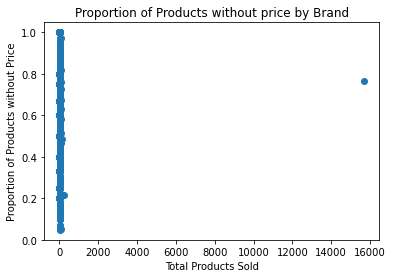

In [223]:
plt.scatter(price_exist['total'],price_exist['no_price']/price_exist['total'],)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by Brand");


The extreme right point is the one with missing brand name. It probably represents unbranded products. We can disregard those products for now. And to reduce overplotting, we can change the limits of x axis.

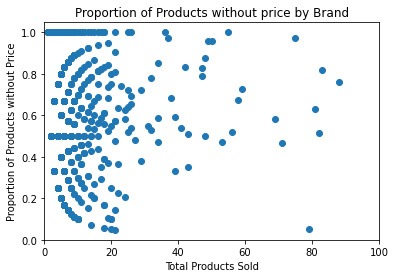

In [225]:
plt.scatter(price_exist['total'],price_exist['no_price']/price_exist['total'],)
plt.xlim(0,100)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by Brand");

But this plot includes a lot of brands which only ever sold a few products and then shut down. Let's just look at the active brands. These are the brands which have atleast a few products with prices.

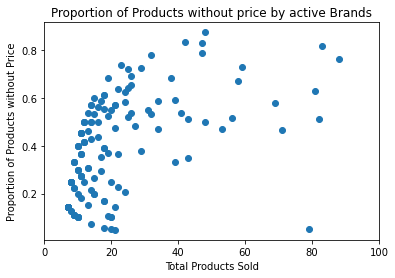

In [229]:
filtered = price_exist['with_price']>5
x = price_exist.loc[filtered,'total']
y = price_exist.loc[filtered,'no_price']/price_exist.loc[filtered,'total']
plt.scatter(x,y)
plt.xlim(0,100)
plt.xlabel("Total Products Sold")
plt.ylabel("Proportion of Products without Price")
plt.title("Proportion of Products without price by active Brands");

There is a positive correlation between the total number of products sold by active brands and the proportion of product without prices. This tells us that larger the brand the quicker they upgrade their inventory on Amazon.

#### 2. Extracting the sentiment of the reviews

We will now proceed with extracting the sentiment from the reviews. We will then compare it with the rating and see what correlations we expect. One should expect a positive correlation. We will then compare sentiment against the prices

We shall be using VADER. The cell below loads the data containing all sentiments into a dataframe called `sent`

In [3]:
print(''.join(open("data/vader_lexicon.txt").readlines()[:10]))
sent = pd.read_csv('data/vader_lexicon.txt',sep = '\t',index_col=0,header=None, usecols = [0,1], names = ['token',"polarity"])
sent.head()

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



NameError: name 'pd' is not defined

Let's again look at the `reviews` dataframe

In [178]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


We are interested in the `reviewText`

Before moving ahead we need to first remove all the punctuation. Below is a regex which will capture all the punctuations within text.

In [179]:
punct_re = r'[^\w_\s]'

def sanitize_texts(df):
    punct_re = r'[^\w_\s\n]'    
    df["clean_text"] = df['reviewText'].str.lower().str.replace(punct_re," ",regex = True)
    df["clean_summary"] = df['summary'].str.lower().str.replace(punct_re," ",regex = True)
    return df

reviews = sanitize_texts(reviews)
reviews["clean_text"].head()

0                                                great
1    my  husband wanted to reading about the negro ...
2    this book was very informative  covering all a...
3    i am already a baseball fan and knew a bit abo...
4    this was a good story of the black leagues  i ...
Name: clean_text, dtype: object

In [180]:
reviews["unixReviewTime"].value_counts()

1456790400    515
1468800000    469
1468454400    430
1461024000    426
1462147200    412
             ... 
1016064000      1
1076284800      1
1105056000      1
1007856000      1
1119225600      1
Name: unixReviewTime, Length: 5288, dtype: int64

It seems our review dataset doesn't have a primary key. Let's create one!!

In [182]:
reviews["primary_key"] = reviews.index

In [183]:
reviews["primary_key"].value_counts()

2047      1
316111    1
271057    1
277202    1
275155    1
         ..
3499      1
13740     1
15789     1
9646      1
0         1
Name: primary_key, Length: 371345, dtype: int64

We ended up using the index as our primary key.

In [184]:
def to_tidy_format(df):
    tidy = (
        df["clean_text"]
        .str.split()
        .explode()
        .to_frame()
        .rename(columns={"clean_text": "word"})
    )
    return tidy

tidyReviewText = to_tidy_format(reviews)
tidyReviewText.head()

,word
0,great
1,my
1,husband
1,wanted
1,to


Adding in the Polarity Score:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each review: we can join the table with the lexicon table. 

In [185]:
def add_polarity(df, tidy_df):
    df["polarity"] = (
        tidy_df
        .merge(sent, how='left', left_on='word', right_index=True)
        .reset_index()
        .loc[:, ['index', 'polarity']]
        .groupby('index')
        .sum()
        .fillna(0)
    )
    return df

reviews = add_polarity(reviews, tidyReviewText)
reviews.query("polarity<0")

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,clean_text,clean_summary,primary_key,polarity
9,1.0,True,"11 19, 2016",AMACNEW14ADMX,014789302X,rabiyaa123,it burns your eyes when u put it on and very ...,i do not recommend.,1479513600,3,NaN,NaN,it burns your eyes when u put it on and very ...,i do not recommend,9,-1.8
94,5.0,True,"02 28, 2018",AAVTF1ADARRTU,1620213982,Henry Sanchez,Its the right size for the right product. Its...,Perfect Holder for my razor and brush,1519776000,NaN,{'Size:': ' 6.25 Inches'},NaN,its the right size for the right product its...,perfect holder for my razor and brush,94,-1.6
156,5.0,True,"12 17, 2017",A122O00K0Y3ET3,1620213982,Michael T.,It's fine. Wanted to order a replacement for t...,It's fine. Wanted to order a replacement for t...,1513468800,NaN,{'Size:': ' 6.25 Inches'},NaN,it s fine wanted to order a replacement for t...,it s fine wanted to order a replacement for t...,156,-2.3
186,4.0,True,"10 31, 2017",A2D2P3PXKRDVZ8,1620213982,Gutz-42,I have had it a couple of weeks and works fine...,... have had it a couple of weeks and works fi...,1509408000,NaN,{'Size:': ' 6.25 Inches'},NaN,i have had it a couple of weeks and works fine...,have had it a couple of weeks and works fi...,186,-0.9
189,2.0,True,"10 25, 2017",A25NTNX0RLFZD3,1620213982,Robert McLeod,My shving brush was too large in diameter. Tr...,Do not adjust,1508889600,NaN,{'Size:': ' 6.25 Inches'},NaN,my shving brush was too large in diameter tr...,do not adjust,189,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371299,1.0,True,"05 22, 2017",A29I4UGV40K8QO,B01HI75KNE,NICOLE SALMON,"The dryer is a disappointment, too heavy , but...","The dryer is a disappointment, too heavy",1495411200,NaN,NaN,NaN,the dryer is a disappointment too heavy but...,the dryer is a disappointment too heavy,371299,-4.4
371329,1.0,True,"04 21, 2017",A31CW6M6DOT894,B01HJ1K3YK,Cookie,Very misleading advertising. The price is onl...,One Star,1492732800,NaN,NaN,NaN,very misleading advertising the price is onl...,one star,371329,-1.7
371336,2.0,True,"06 27, 2018",AF3SZ7YB5M3Q5,B01HJEGTYK,Deb Magelssen,It's hard to match hair color.,It's hard to match hair color.,1530057600,NaN,NaN,NaN,it s hard to match hair color,it s hard to match hair color,371336,-0.4
371340,1.0,True,"07 20, 2017",A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,1500508800,NaN,NaN,NaN,it was awful it was super frizzy and i tried ...,it was super frizzy and i tried to comb it and...,371340,-0.9


With the polarity in place, let's see how polarity correlates with rating. We'll first do so without grouping by product and just focus on reviews.

(-100.0, 100.0)

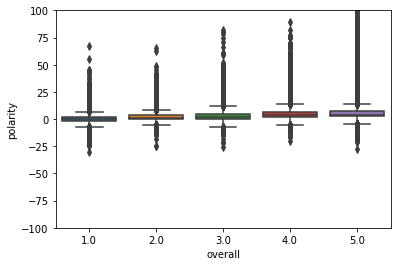

In [186]:
sns.boxplot(x="overall",y ="polarity",data = reviews)
plt.ylim(-100,100)

This is as one would expect that the polarity of reviews would go up as the rating increases. Indeed, this is the case. Let's compare the correlation now for verified and non-verified users separately and we focus only on the IQR regions and not worry about outliers.

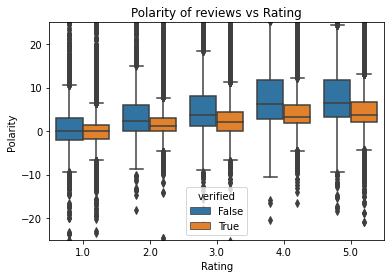

In [232]:
sns.boxplot(x="overall",y ="polarity",data = reviews, hue = 'verified')
plt.ylim(-25,25)
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.title("Polarity of reviews vs Rating");

Verified users have a narrower IQR. This is because number of verified users is way more than the number of unverified users. Hence, more variability is encountered in unverified users response.

In [233]:
reviews['verified'].value_counts()

True     322473
False     48872
Name: verified, dtype: int64

#### 3. Sales Rank vs Avg Rating

#### Is there any correlation between the variables you are interested in exploring?
Correlations explored:
1. Proportion of products by brand in the dataset without prices vs total products sold by that brand:
   We observed that there was poitive correlation. Which meand uf a brand sold a larger number of products, it will have more products without prices. This shows that larger brands have to keep upgrading their inventory on Amazon to thrive.
2. Polarity of ReviewText vs Rating: Positive correlation

## Modeling

Modeling Utility functions:

In [165]:
def transform_col(data, func, feat, new_feat):
    data[new_feat] = func(metadata_with_ratings[feat])
    data[new_feat].describe()

def extract_words(data, feat, max_words=100, encoder=None, output=True):
    if not encoder:
        encoder = CountVectorizer(max_features=max_words, stop_words='english')
        encoder.fit(data[feat])
    X = encoder.transform(data[feat]).toarray()

    if output:
        print('first 50 features:', encoder.get_feature_names()[:50])
        print('feature matrix shape', X.shape)
    return X, encoder

def onehot_encode(data, feat, max_categories=100, encoder=None):
    cat_counts = data[feat].value_counts()
    categories = cat_counts[1:max_categories + 1].index.tolist()
    raw_features = data[feat].to_numpy()[:,None]
    if not encoder:
        encoder = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse=False)
        encoder.fit(raw_features)
    return encoder.transform(raw_features), encoder

def fill_missing(data, feat, imputer=None):
    if not imputer:
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

def standardize(X, scale_columns, encoder=None, output=True):
    X_to_scale = X[:,scale_columns]
    if not encoder:
        encoder = StandardScaler()
        encoder.fit(X_to_scale)
    X[:,scale_columns] = encoder.transform(X_to_scale)
    if output:
        print('mean:', encoder.mean_)
        print('standard deviation:', encoder.scale_)
    return X, encoder

numerical_features = ['price_float', 'sq_price', 'brand_count', 'sq_brand_count', 'top_brand']
standardize_cols = [0, 1, 2, 3]

def get_feat_matrix(data, encoders=None):
    if not encoders:
        encoders = [None, None, None, None]
    X1 = data[numerical_features].to_numpy()
    X2, encoders[0] = onehot_encode(data, 'brand', encoder=encoders[0])
    X3, encoders[1] = extract_words(data, 'title', encoder=encoders[1], output=False)
    X4, encoders[2] = extract_words(data, 'description_str', 500, encoder=encoders[2], output=False)
    X = np.hstack([X1, X2, X3, X4])
    X, encoders[3] = standardize(X, standardize_cols, encoder=encoders[3], output=False)
    return X, encoders

def get_feature_names(encoders):
    features = np.append(numerical_features, encoders[0].get_feature_names())
    features = np.append(features, np.char.add('title_', encoders[1].get_feature_names()))
    features = np.append(features, np.char.add('descr_', encoders[2].get_feature_names()))
    return features

def train_test_split(data, label):
    data_train, data_test, y_train, y_test = \
            model_selection.train_test_split(data, data[label], test_size=0.2, random_state=314)
    clean_features(data_train, training_data=data_train, output=False)
    clean_features(data_test, training_data=data_train, output=False)
    X_train, encoders = get_feat_matrix(data_train)
    X_test, _ = get_feat_matrix(data_test, encoders=encoders)
    print(f'Training data of shape {X_train.shape}, test data {X_test.shape}')
    return X_train, X_test, y_train, y_test

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mean_proportional_error(y, y_pred):
    return np.sqrt(np.mean(((y - y_pred) / y)**2))

def train_ridge(X_train, X_test, y_train, y_test):
    alpha_exponents = np.arange(-5, 5, 0.2) * np.log(10)
    model = RidgeCV(alphas=np.exp(alpha_exponents))
    return train_model(X_train, X_test, y_train, y_test, model)
    
def train_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    train_loss = rmse(y_train, y_train_pred)
    test_loss = rmse(y_test, y_test_pred)
    train_err = mean_proportional_error(y_train, y_train_pred)
    test_err = mean_proportional_error(y_test, y_test_pred)
    
    print('training r^2:', train_r2)
    print('test r^2:', test_r2)
    print('training loss:', train_loss)
    print('test loss:', test_loss)
    print('training proportional loss:', train_err)
    print('test proportional loss:', test_err)
    return model

In [166]:
label = 'sqrt_rank'

In [167]:
X_train, X_test, y_train, y_test = train_test_split(metadata_available, label)

Training data of shape (8889, 705), test data (2223, 705)


### Ridge regression

In [169]:
model = train_ridge(X_train, X_test, y_train, y_test)

training r^2: 0.1290137903390789
test r^2: 0.05060148200534276
training loss: 342.12469890208564
test loss: 346.91120540853876
training proportional loss: 1.659897619842171
test proportional loss: 2.8809392428885934


In [170]:
np.round(model.coef_ * 10).astype(int)

array([ 693, -440, -160,  349,   57,   48,   36,   19,    2,   -5,    2,
         24, -124,   54,  -26,  -29,   99,   -7,   89,  -95,  205,  -25,
        -37,   70,  -42, -129,  135,    3,   27,  -64,   21,   30,   39,
        -69,   15,   17,   60, -109,  -51,   12,    8,    1,   14,  -24,
         27,  -58,  -99,  -39,  -31,  -11,   11,  -48,   16,   23,  -26,
         32,  -41,   -6,  -48,  -59,    4,  -46,   15,   54, -101,  -16,
        -41,   23,  -13,  -26,  -29,  -64,   -7,   26,   -2,   41,   25,
          1,  -38,  -17,   13,  -38,  -36,  -30,   -9,  -30,   28,  -19,
         37,   -7,   30,  -51,  -11,   -8,  -31,   25,  -35,    0,  -30,
          8,  -11,   55,   31,   25,  -32,  -14,  -71,  -73,   50,   26,
       -153,  -62,  -84, -219,  137,   59, -119,   16,  318,   94,  107,
         29,  135,  -12,  -57,   38,  -32,  179,   25, -129,  -59,   17,
        205,  -58,  -86, -310, -332,   28,  -53,  -52,  139,   27,   20,
       -246, -119,   47,   97, -126, -115,   97,   

In [192]:
n = 5
feats = get_feature_names(None)
top_coefs = np.argsort(-np.abs(model.coef_))[:n]
print('top features for Ridge model:', feats[top_coefs])

TypeError: 'NoneType' object is not subscriptable

### Random forest

In [193]:
# Setting n_estimators to be greater increases r^2 slightly but takes much longer, so I just went with
# the default. Set n_jobs to make it faster.
model = train_model(X_train, X_test, y_train, y_test, RandomForestRegressor(max_depth=27, n_jobs=4))

training r^2: 0.5104076264677603
test r^2: 0.1295601458891057
training loss: 256.50516282185976
test loss: 332.17231790662316
training proportional loss: 0.8914759825516005
test proportional loss: 1.9412341338033103


### SVM

In [173]:
# May take several minutes to train.
model = train_model(X_train, X_test, y_train, y_test, SVR(C=250))

training r^2: 0.25897563232075194
test r^2: 0.11712885367076808
training loss: 315.5695085585726
test loss: 334.5358885168373
training proportional loss: 1.2870068428920107
test proportional loss: 2.0201616210398874


Here are a few components your notebook must address:
- What type of machine learning problem are you investigating?
- What model do you plan on using and why?
- Does your model require hyperparameter tuning? If so, how do you approach it?
- How do you engineer the features for your model? What are the rationales behind selecting these features?
- How do you perform cross validation on your model?
- What loss metrics are you using to evaluate your model?
- From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?
- How would you improve your model based on the outcome?